# Word similarity

Community is an [ambiguous sociological concept](https://ccgilroy.github.io/gilroy-reading-list/rationale.html#narrative-rationale). "Community" can index moral unity, an emotional sense of togetherness, common interests, interactional social density, or geographic proximity, and I doubt that list is exhaustive. 

Word embeddings provide one way to investigate the meaning of community in natural language. If a general initial investigation reveals something robust and interesting, then that could motivate applying word embeddings to specific data sets of analytic interest, and suggest which approaches might be the most productive.

Word embeddings encode meaning relationally. This makes embeddings useful for assessing the similarity between words. Querying a model for which words are most similar to a target word is a starting point for assessing what that target word means in the context of the model.

At the same time, word embeddings aren't necessarily stable ([Antoniak and Mimno 2018](https://mimno.infosci.cornell.edu/papers/antoniak-stability.pdf), Rodriguez and Spirling 2020). And embeddings trained on different data sources might encode biases or particularities -- which could be a nuisance we'd want to mitigate, or which could themselves be the object of investigation.

When working with embeddings for social-scientific ends, a major analytic choice is whether to use pretrained embeddings or to train a new model on a local data source (Rodriguez and Spirling 2020, Stoltz and Taylor 2020). Generally, social scientists who have worked with word embeddings recommend starting with pretrained models, and I perceive them to be optimistic overall about the applicability of those pretrained models to specific local contexts. Because of that, I'll start here by examining a few pretrained models, rather than seeking out a relevant corpus to train my own model on. I'll compare two pretrained GloVe models -- one based on Wikipedia, and one based on Twitter -- and describe a few others I considered.

## Comparing pretrained vectors

The gensim package distributes versions of pretrained models through gensim-data: https://github.com/RaRe-Technologies/gensim-data

https://rare-technologies.com/new-download-api-for-pretrained-nlp-models-and-datasets-in-gensim/

If a model exists there, this is more convenient than finding and loading it from the original source (which is often idiosyncratic research code). The original source for the GloVe models is https://nlp.stanford.edu/projects/glove/

### GloVe - twitter 

In gensim-data. Year unspecified. 

### GloVe - wikipedia 2014 + gigaword 5

In gensim-data. Gigaword is a newswire corpus: https://catalog.ldc.upenn.edu/LDC2011T07

I'll refer to these as the "wikipedia" vectors as a shorthand, but that's not *all* of the training data! Social scientists might prefer models trained on a single data source for consistency, but NLP practitioners seem to prefer the better performance they get from using more data.

### GloVe - common crawl

There's a third data set used to produce pretrained GloVe vectors - the common crawl of internet data. This isn't packaged in gensim-data, but it is the source of the English model vectors in the spaCy package: https://spacy.io/models/en

spaCy models can also be loaded in whatlies, and I've explored this in a previous iteration of this notebook. It was interesting, but I'll leave it aside for simplicity's sake. 

### word2vec - google news

In gensim-data. These vectors are very large and memory-intensive. The large "vocabulary" includes many spelling variants, and so it wasn't that helpful in my initial exploration. I don't cover it here. Original source: https://code.google.com/archive/p/word2vec/


## Notes on packages

A word embeddings model is a vocabulary list ("keys") and a matrix of vectors for each word in the vocabulary. But different Python packages have different interfaces for performing operations using the model, and they can be more or less convenient for particular tasks. Learning multiple object APIs is a recipe for confusion, but sometimes a method just isn't available. 

**gensim** is the standard python package for training word2vec models, and it's a good package for working with GloVe embeddings as well. 

**whatlies** is a newer package from an NLP company called Rasa (Warmerdam, Kober and Tatman 2020). It's meant to facilitate visualization and comparison within and across different models. The API is a bit more abstract, which can be really nice when it works.

I'll switch between the two packages depending on the task, though I found whatlies particularly convenient for this notebook.

## Load packages and models

In [1]:
# load packages
import os

import gensim.downloader as api

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from whatlies import Embedding, EmbeddingSet
from whatlies.transformers import Pca
# from whatlies.language import GensimLanguage, SpacyLanguage

from scipy import stats

In [2]:
# load models
# load gensim vectors (as KeyedVectors)
wv_wiki = api.load("glove-wiki-gigaword-200")
if not os.path.isfile("glove-wiki-gigaword-200.kv"):
    wv_wiki.save("glove-wiki-gigaword-200.kv")
    
wv_twitter = api.load("glove-twitter-200")
if not os.path.isfile("glove-twitter-200.kv"):
    wv_twitter.save("glove-twitter-200.kv")

## Subset to common vocabulary

In [3]:
print('Wiki vocab: {}'.format(len(wv_wiki.vocab.keys())))
print('Twitter vocab: {}'.format(len(wv_twitter.vocab.keys())))

Wiki vocab: 400000
Twitter vocab: 1193514


The Wikipedia model's vocabular is capped at 400K words; the Twitter vocabulary is much larger. Given how many words are in common usage in English, both vocabularies likely include many rare or idiosyncratic terms. 

In [4]:
# load vectors as whatlies EmbeddingSet
emb_wiki = EmbeddingSet.from_names_X(names=wv_wiki.vocab.keys(), 
                                     X=wv_wiki.vectors)
emb_twitter = EmbeddingSet.from_names_X(names=wv_twitter.vocab.keys(),
                                       X = wv_twitter.vectors)

In [5]:
# subset vocabulary
vocab_wiki = set(wv_wiki.vocab.keys())
vocab_twitter = set(wv_twitter.vocab.keys())
common_vocab = vocab_wiki & vocab_twitter # intersection

In [6]:
len(common_vocab)

150396

In [7]:
# other set operations:
len(vocab_wiki | vocab_twitter) # union 
len(vocab_wiki - vocab_twitter) # difference
len(vocab_twitter - vocab_wiki) # the other difference

1043118

These set operations are based on this gist: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf#file-gensim_word2vec_procrustes_align-py-L36

It's kind of interesting to look at what words are absent from one vocabulary or the other. Most are obscure, proper names, etc, but what about words like "indelicate" or "presuppose" or "assailed"? (A few words in the wiki vocab but not the twitter vocab.)

A fair amount of the twitter vocab missing from the wiki vocab is ... not actually English. (e.g. '想像しただけで' ~ "just by having imagined", '覚えておいてね' ~ "remember it, okay", or even the whole sentence '古いアップルファンとしては６色カラーにある種のノスタルジーを感じずにはいられません'). Do those come from tweets that mixed languages? Or is language classification just not very precise?

In [8]:
# being able to do this is nice! thanks, whatlies
emb_wiki_sub = emb_wiki[common_vocab]
emb_twitter_sub = emb_twitter[common_vocab]

## What words are most similar to "community"?

In [9]:
# list similar words
emb_wiki_sub.score_similar("community", n=10)

[(Emb[community], 0.0),
 (Emb[communities], 0.18838828802108765),
 (Emb[organizations], 0.3966641426086426),
 (Emb[society], 0.40596723556518555),
 (Emb[local], 0.4114809036254883),
 (Emb[established], 0.4117661118507385),
 (Emb[area], 0.4153445363044739),
 (Emb[part], 0.42497074604034424),
 (Emb[within], 0.4256446957588196),
 (Emb[public], 0.42661720514297485)]

In [10]:
emb_twitter_sub.score_similar("community", n=10)

[(Emb[community], 1.1920928955078125e-07),
 (Emb[youth], 0.31809890270233154),
 (Emb[development], 0.3404795527458191),
 (Emb[communities], 0.3463841676712036),
 (Emb[culture], 0.36351752281188965),
 (Emb[forum], 0.3643679618835449),
 (Emb[center], 0.36664193868637085),
 (Emb[social], 0.3729069232940674),
 (Emb[organization], 0.3769025206565857),
 (Emb[arts], 0.37739789485931396)]

The metric returned here is cosine *distance* (so smaller = more similar).

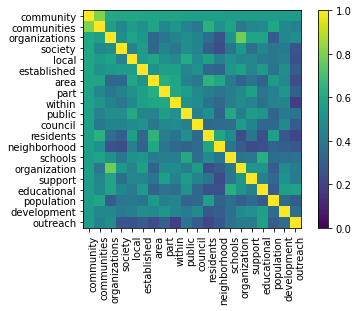

In [11]:
# plot similar words (heatmap)
emb_wiki_sub.embset_similar('community', n=20).plot_similarity()

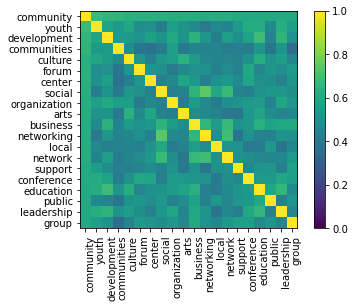

In [12]:
(emb_twitter_sub
 .embset_similar("community", n=20, metric="cosine")
 .plot_similarity(metric="cosine"))

## Dimensionality reduction

What variation exists *within* the local neighborhood of the vector space around "community"? 

Dimensionality reduction methods are one way to explore this local variation. The whatlies package has a set of transformers, borrowed from scikit-learn, that make this easy, including PCA, UMAP, and t-SNE. 

I'll start with PCA, which is relatively straightforward and familiar to social scientists. I'll plot the first two principal components for the vectors of the 100 embeddings closest to community (by cosine similarity). This isn't PCA for the *whole* set of vectors; it's meant to highlight the variation in a set of vectors that are already similar to each other.

TODO: 

- show % of variation explained by each component
- actually cluster the words in the local neighborhood, rather than looking for visual separation
- find a more systematic way of defining the cutoff for nearest neighbors, or at least do a sensitivity analysis for N

In [13]:
# get 100 most similar words
wiki_com100 = emb_wiki_sub.embset_similar("community", n=100, metric='cosine')
twitter_com100 = emb_twitter_sub.embset_similar("community", n=100, metric='cosine')

In [14]:
wiki_com100.transform(Pca(2)).plot_interactive()

alt.LayerChart(...)

In [15]:
twitter_com100.transform(Pca(2)).plot_interactive()

alt.LayerChart(...)

## Correlation across models

How similar are these two sets of embeddings for "community"? I'll implement a method from a paper by Rodriguez and Spirling to investigate.

Rodriguez and Spirling (2020 / forthcoming) investigate the correlation between nearest-neighbors rankings across models, for queries of particular words. Personally, I wasn't completely confident I understood what they were doing from the text of the paper alone. Fortunately, Rodriguez has a GitHub repository with R implementations of some of their methods: https://github.com/prodriguezsosa/weeval. Spirling hosts the paper and an FAQ on a separate repository [here](http://github.com/ArthurSpirling/EmbeddingsPaper). 

These are the relevant functions: 

- https://github.com/prodriguezsosa/weeval/blob/master/R/corr_embeds.R
- https://github.com/prodriguezsosa/weeval/blob/master/R/cue_sim.R

The method is 

1) For each model, calculate a similarity measure (cosine similarity) between a single word and the entire common vocabulary.
2) With each word in the vocabulary as a data point, calculate the correlation (Pearson or Spearman) between the two similarity measures.

Their code seems like it norms the vectors too, though (as usual) it's not clear whether that will change the final metric. 

`EmbeddingSet.score_similar()` produces cosine distances, which are a linear transformation of cosine similarities (1 - sim), so the correlation should be identical. 

In the appendix of their paper, Rodriguez and Spirling use the Jaccard index as an alternative. That's a more formal version of something I tried in my first exploration of similarity, looking at the overlap in the sets of nearest neighbors. I might return to that measure later. (Note, for Jaccard similarity it might not make sense to subset to the common vocabulary?)

In [16]:
# calculate similarity across entire common vocabulary
# (I already subset the vocabularies above)
sim_wiki = emb_wiki_sub.score_similar("community", n=len(emb_wiki_sub), metric="cosine")

In [17]:
sim_twitter = emb_twitter_sub.score_similar("community", n=len(emb_wiki_sub), metric="cosine")

In [18]:
df_wiki = pd.DataFrame(sim_wiki, 
                       columns=["wiki_embedding", "wiki_cosine_distance"])
df_twitter = pd.DataFrame(sim_twitter, 
                          columns=["twitter_embedding", "twitter_cosine_distance"])

In [19]:
df_wiki["name"] = [e.name for e in df_wiki["wiki_embedding"]]
df_twitter["name"] = [e.name for e in df_twitter["twitter_embedding"]]

In [20]:
# join the two data frames
df = df_wiki.merge(df_twitter, on="name")

In [21]:
stats.pearsonr(df["wiki_cosine_distance"], df["twitter_cosine_distance"])

(0.6358485733592459, 0.0)

In [22]:
stats.spearmanr(df["wiki_cosine_distance"], df["twitter_cosine_distance"])

SpearmanrResult(correlation=0.5001885223836662, pvalue=0.0)

0.636 is a moderately high correlation. When comparing their locally-trained models to a pretrained GloVe model, Rodriguez and Spirling generally conclude that correlations of similar magnitude are "surprisingly" high, and they conclude that the embeddings are substantively similar. 

It might be arguable that we should have expected the correlation to be even higher, given that these are two pretrained models using the same method and a large amount of data - albeit from quite different sources. To contextualize the correlation, I calculate correlations for other query words below.

For completeness, I also visualize the cosine distances from community for the 150396 words in the common vocabulary. (0, 0) is, of course, the word "community" itself.

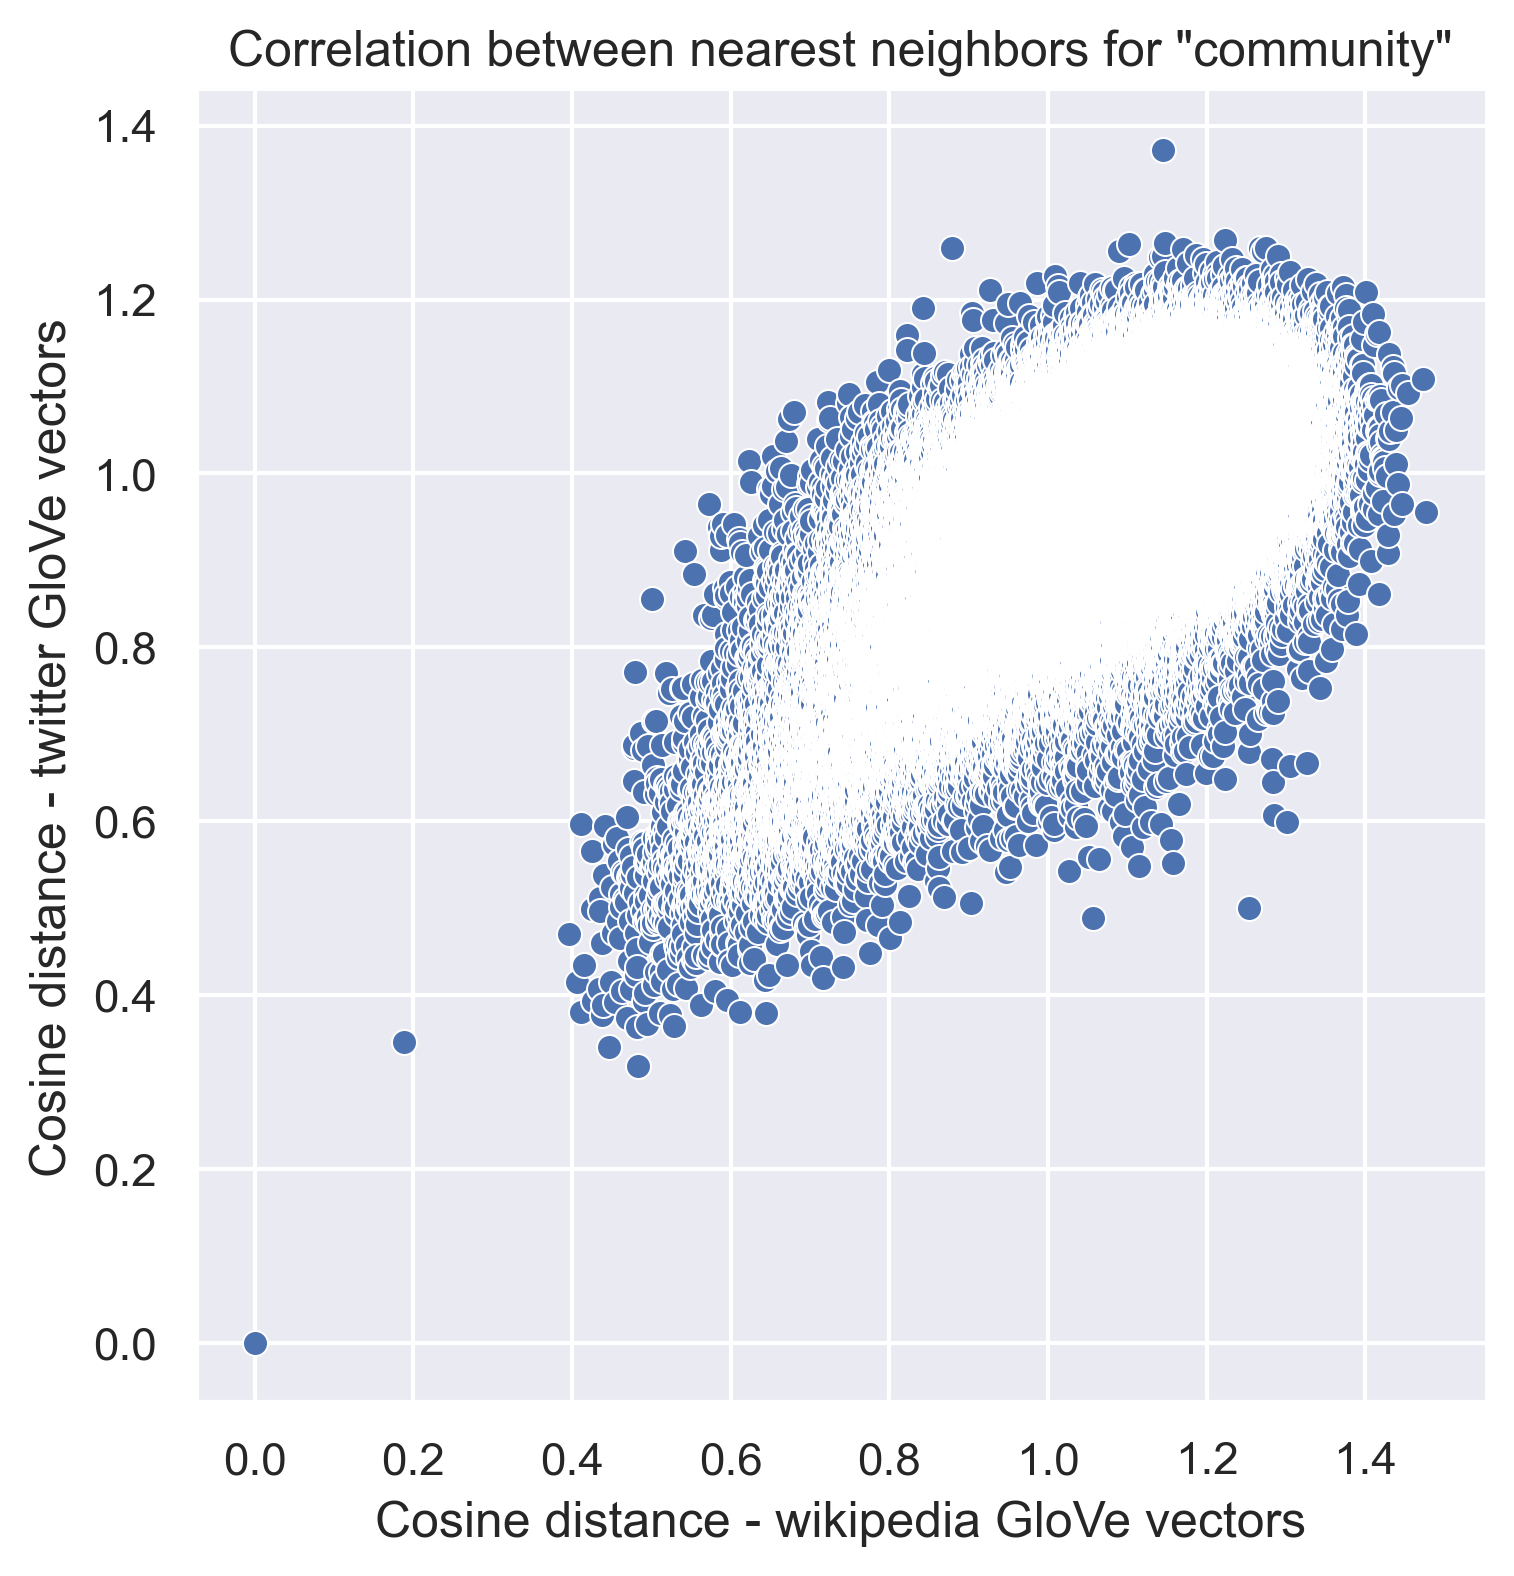

In [23]:
sns.set_style("darkgrid")
sns.set(rc={"figure.dpi":300})
g = sns.relplot(x="wiki_cosine_distance", y="twitter_cosine_distance",
                data=df, kind="scatter")
g.ax.set_title('Correlation between nearest neighbors for "community"')
g.ax.set_xlabel("Cosine distance - wikipedia GloVe vectors")
g.ax.set_ylabel("Cosine distance - twitter GloVe vectors")
plt.show()

Other words

- **Community-related words:** "society"
- **Random words:** "cat", "dog" 
- **Political science words:** "freedom", "democracy" (from Rodriguez and Spirling)



In [24]:
def compare_embedding_similarities(emb1, emb2, word, 
                                   suffixes=("1", "2")):
    sim1 = emb1.score_similar(word, n=len(emb1), metric="cosine")
    sim2 = emb2.score_similar(word, n=len(emb2), metric="cosine")
    
    df1 = pd.DataFrame(sim1, 
                       columns=["embedding", "cosine_distance"])
    df2 = pd.DataFrame(sim2, 
                       columns=["embedding", "cosine_distance"])
    
    df1["name"] = [e.name for e in df1["embedding"]]
    df2["name"] = [e.name for e in df2["embedding"]]
    
    df1 = df1[["name", "embedding", "cosine_distance"]]
    df = df1.merge(df2, on="name", suffixes=suffixes)
    return df
    

In [25]:
compare_embedding_similarities(emb_wiki_sub, emb_twitter_sub, "community", 
                               suffixes=("_wiki", "_twitter"))

,name,embedding_wiki,cosine_distance_wiki,embedding_twitter,cosine_distance_twitter
0,community,community,0.000000,community,1.192093e-07
1,communities,communities,0.188388,communities,3.463842e-01
2,organizations,organizations,0.396664,organizations,4.701583e-01
3,society,society,0.405967,society,4.148523e-01
4,local,local,0.411481,local,3.800470e-01
...,...,...,...,...,...
150391,yae,yae,1.446393,yae,9.652307e-01
150392,belina,belina,1.446450,belina,1.102029e+00
150393,ceniceros,ceniceros,1.453716,ceniceros,1.092436e+00
150394,denni,denni,1.473078,denni,1.108507e+00


In [26]:
df_society = compare_embedding_similarities(emb_wiki_sub, emb_twitter_sub, "society", 
                                            suffixes=("_wiki", "_twitter"))

In [27]:
stats.pearsonr(df_society["cosine_distance_wiki"], 
               df_society["cosine_distance_twitter"])

(0.6388758211279737, 0.0)

In [28]:
df_freedom = compare_embedding_similarities(emb_wiki_sub, emb_twitter_sub, "freedom", 
                                            suffixes=("_wiki", "_twitter"))

In [29]:
stats.pearsonr(df_freedom["cosine_distance_wiki"], 
               df_freedom["cosine_distance_twitter"])

(0.627512182447341, 0.0)

In [30]:
df_democracy = compare_embedding_similarities(emb_wiki_sub, emb_twitter_sub, 
                                              "democracy", 
                                              suffixes=("_wiki", "_twitter")) 

In [31]:
stats.pearsonr(df_democracy["cosine_distance_wiki"], 
               df_democracy["cosine_distance_twitter"])

(0.6114448321728029, 0.0)

In [32]:
df_cat = compare_embedding_similarities(emb_wiki_sub, emb_twitter_sub, 
                                       "cat",
                                        suffixes=("_wiki", "_twitter")) 
df_dog = compare_embedding_similarities(emb_wiki_sub, emb_twitter_sub, 
                                       "dog",
                                        suffixes=("_wiki", "_twitter")) 

In [33]:
stats.pearsonr(df_cat["cosine_distance_wiki"], 
               df_cat["cosine_distance_twitter"])

(0.5612406350431633, 0.0)

In [34]:
stats.pearsonr(df_dog["cosine_distance_wiki"], 
               df_dog["cosine_distance_twitter"])

(0.6200159573034019, 0.0)

These correlations are all in the same range, which leads me to provisionally conclude that "community" isn't unusually unstable or variable between these two data sources. 

Some of the differences between twitter and wikipedia in the nearest neighbors I visualized in the previous sections still seem like they could be substantively meaningful, but I don't want to overinterpret those differences. There's a common core meaning to "community" that's being encoded in these GloVe vectors. 